# Update-Heavy but Enrolment-Light Regions

In [17]:
from book1 import pincode_df

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Re-aggregate to District Level & Filter Noise

In [18]:
# 1. Re-aggregate Pincode data back to District Level for Regional Analysis
region_df = pincode_df.groupby(['state', 'district'])[[
    'total_enrolments', 'demo_activity', 'bio_activity'
]].sum().reset_index()

# 2. Calculate Total Activity
region_df["total_activity"] = (
    region_df["total_enrolments"] +
    region_df["demo_activity"] +
    region_df["bio_activity"]
)

# 3. Apply Minimum Volume Filter (Fixes "Small Number Noise")
# We only analyze districts with significant activity (> 1000 transactions)
VOLUME_THRESHOLD = 1000
region_df = region_df[region_df["total_activity"] > VOLUME_THRESHOLD].copy()

## Compute Split Update Ratios (Bio vs Demo)

In [19]:
# We calculate separate ratios to distinguish infrastructure needs
# Bio Ratio -> Need for Iris/Fingerprint Scanners
# Demo Ratio -> Need for Data Entry Terminals

region_df["bio_to_enrol_ratio"] = (
    region_df["bio_activity"] / region_df["total_enrolments"].replace(0, np.nan)
)

region_df["demo_to_enrol_ratio"] = (
    region_df["demo_activity"] / region_df["total_enrolments"].replace(0, np.nan)
)

# Total Maintenance Ratio (for sorting)
region_df["total_maintenance_ratio"] = region_df["bio_to_enrol_ratio"] + region_df["demo_to_enrol_ratio"]

In [20]:
region_df[
    ["state", "district", "total_enrolments", "bio_to_enrol_ratio", "demo_to_enrol_ratio"]
].describe()

,total_enrolments,bio_to_enrol_ratio,demo_to_enrol_ratio
count,912.000000,912.000000,912.000000
mean,5946.028509,16.203373,10.894302
std,6675.810524,11.902362,7.364303
min,9.000000,0.000000,0.000000
25%,1155.500000,8.419313,6.685612
50%,3770.500000,13.560793,9.629395
75%,7987.000000,21.817794,13.138523
max,43688.000000,156.888889,76.490347


## Identify Update-Heavy

In [21]:
ratio_threshold = region_df["total_maintenance_ratio"].quantile(0.90)

update_heavy = region_df[
    region_df["total_maintenance_ratio"] >= ratio_threshold
].sort_values("total_maintenance_ratio", ascending=False)

In [22]:
update_heavy.head(10)

,state,district,total_enrolments,demo_activity,bio_activity,total_activity,bio_to_enrol_ratio,demo_to_enrol_ratio,total_maintenance_ratio
212,Daman & Diu,Daman,9,377.0,1412.0,1798.0,156.888889,41.888889,198.777778
587,Manipur,Thoubal,1067,59243.0,56043.0,116353.0,52.523899,55.522962,108.046860
580,Manipur,Imphal East,1132,55983.0,59255.0,116370.0,52.345406,49.454947,101.800353
614,Mizoram,Serchhip,102,2455.0,7604.0,10161.0,74.549020,24.068627,98.617647
581,Manipur,Imphal West,1236,59347.0,61307.0,121890.0,49.601133,48.015372,97.616505
195,Chhattisgarh,Mohla-Manpur-Ambagarh Chouki,259,19811.0,4595.0,24665.0,17.741313,76.490347,94.231660
214,Daman and Diu,Daman,58,1104.0,4033.0,5195.0,69.534483,19.034483,88.568966
213,Daman & Diu,Diu,12,267.0,773.0,1052.0,64.416667,22.250000,86.666667
167,Chhattisgarh,Balod,1678,59706.0,81180.0,142564.0,48.379023,35.581645,83.960667
51,Andhra Pradesh,Warangal,1059,34682.0,51642.0,87383.0,48.764873,32.749764,81.514636


## Visualization: Maintenance-Heavy Districts by Dominant Need

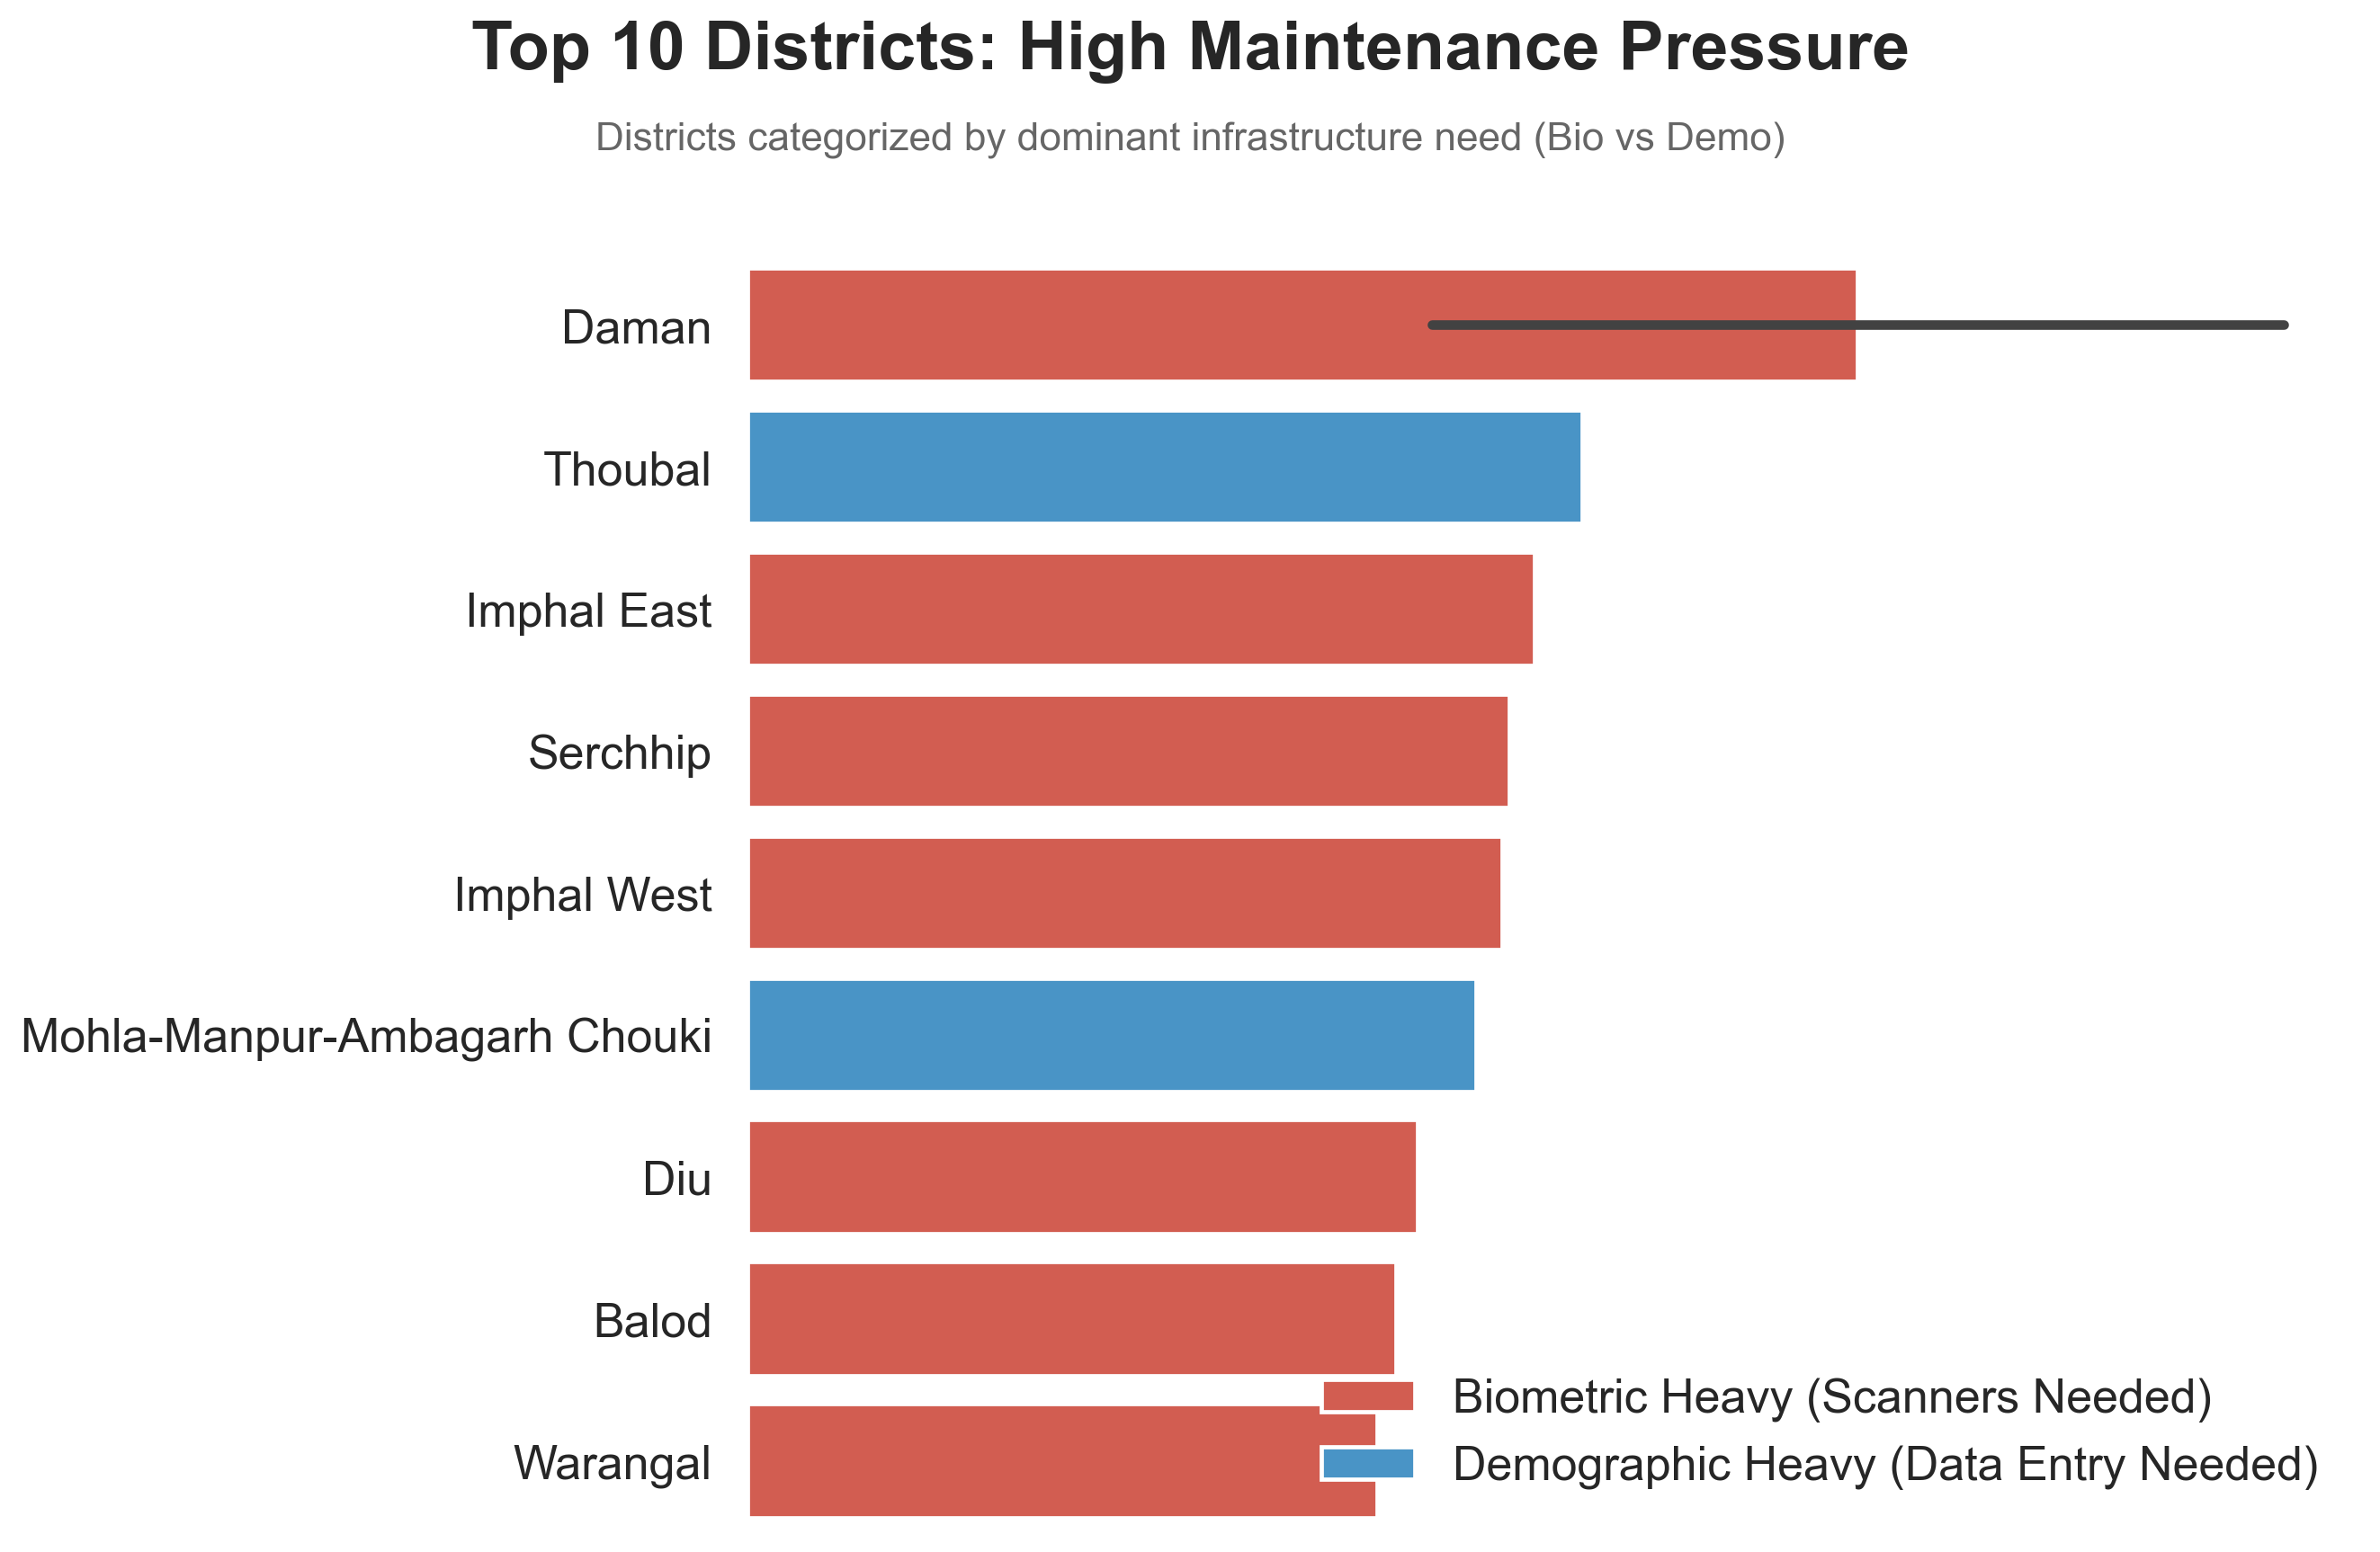

In [23]:
sns.set_context("talk")
sns.set_style("white")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 227

# Fix the Warning: Use .copy() to create a standalone table
top10_maintenance = update_heavy.head(10).copy()

# Determine Dominant Need for coloring
def get_dominant_need(row):
    if row['bio_to_enrol_ratio'] > row['demo_to_enrol_ratio']:
        return 'Biometric Heavy (Scanners Needed)'
    else:
        return 'Demographic Heavy (Data Entry Needed)'

top10_maintenance['dominant_need'] = top10_maintenance.apply(get_dominant_need, axis=1)

# This fixes "Medchal?malkajgiri" -> "Medchal-Malkajgiri"
if 'district' in top10_maintenance.columns:
    top10_maintenance['district'] = top10_maintenance['district'].astype(str).str.replace('?', '-')

# Create the Plot
ax = sns.barplot(
    data=top10_maintenance,
    y="district",
    x="total_maintenance_ratio",
    hue="dominant_need",
    palette={"Biometric Heavy (Scanners Needed)": "#e74c3c", "Demographic Heavy (Data Entry Needed)": "#3498db"},
    dodge=False
)

# --- CENTER ALIGNED TITLES ---
plt.figtext(0.5, 0.93, "Top 10 Districts: High Maintenance Pressure", 
            fontsize=24, weight='bold', ha='center')

plt.figtext(0.5, 0.88, "Districts categorized by dominant infrastructure need (Bio vs Demo)", 
            fontsize=14, color='#666666', ha='center')

# --- LEGEND LOWER RIGHT ---
sns.move_legend(
    ax, "lower right",
    bbox_to_anchor=(1, 0), 
    title="",
    frameon=False,
)

# Clean Axes
plt.xlabel("")
plt.ylabel("")
plt.xticks([]) 
sns.despine(left=True, bottom=True)

# THE LAYOUT FIX
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

## Contrast Check

In [24]:
# Comparing with high enrolment districts to see the difference
region_df.sort_values(
    "total_enrolments", ascending=False
)[
    ["state", "district", "total_enrolments", "total_maintenance_ratio"]
].head(10)

,state,district,total_enrolments,total_maintenance_ratio
572,Maharashtra,Thane,43688,23.310680
160,Bihar,Sitamarhi,42232,8.331218
910,Uttar Pradesh,Bahraich,39338,7.900122
1044,West Bengal,Murshidabad,35911,16.458105
1057,West Bengal,South 24 Parganas,33540,18.654800
563,Maharashtra,Pune,31763,32.874036
771,Rajasthan,Jaipur,31146,20.266102
397,Karnataka,Bengaluru,30980,19.398515
983,Uttar Pradesh,Sitapur,30854,14.054353
164,Bihar,West Champaran,30438,13.148137


## Insight: Update-Heavy but Enrolment-Light Regions

### Several districts exhibit update activity that is disproportionately high relative to their enrolment volume.

By splitting the ratios, we can now distinguish the specific infrastructure need:
- **Biometric Heavy:** Regions where older residents are updating biometrics (Requires Scanners).
- **Demographic Heavy:** Regions with high migration or address changes (Requires Data Entry).

This indicates that operational load in these regions is driven primarily by
identity maintenance rather than new enrolments.

Such districts require:
- Update-focused infrastructure planning
- Capacity allocation based on lifecycle load, not population size

*Note: We applied a volume filter (>1000) to ensure these are significant operational centers, not statistical noise.*

This insight is derived entirely from relative, aggregated metrics and avoids
assumptions about individual behavior.